In [78]:
from math import ceil
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import QFT
import numpy as np
import math
from fractions import Fraction

# Grover search algorithm

In [2]:
def prepareGroverBlackBox(qubits: int, markedNumber: int):
    blackBox = QuantumCircuit(qubits, name="Grover's Black Box")
    if 2**(qubits-1)-1 < markedNumber:
        raise Exception('markedNumber is too Big')
    matrix = np.zeros((2**qubits, 2**qubits))
    for i in range(2**(qubits-1)):
        binaryNumber = bin(i)[2:].rjust(qubits-1, '0')
        if i == markedNumber:
            matrix[int(binaryNumber+'0', 2)][int(binaryNumber+'1', 2)] = 1
            matrix[int(binaryNumber+'1', 2)][int(binaryNumber+'0', 2)] = 1
        else:
            matrix[int(binaryNumber+'0', 2)][int(binaryNumber+'0', 2)] = 1
            matrix[int(binaryNumber+'1', 2)][int(binaryNumber+'1', 2)] = 1
    blackBox.unitary(matrix, range(qubits))
    return Operator(blackBox).to_instruction()

def inversionAboutMean(qubits: int):
    matrix = 2*np.full((2**qubits, 2**qubits), 1/(2**qubits)) - np.eye(2**qubits)
    inversionAboutMean = QuantumCircuit(qubits, name="Inversion About Mean")
    inversionAboutMean.unitary(matrix, range(qubits))
    return Operator(inversionAboutMean).to_instruction()
    
def grover(qubits: int, markedNumber:int):
    qc = QuantumCircuit(qubits+1, qubits)
    qc.x(qubits)
    qc.barrier()
    qc.h(range(qubits+1))
    numIterations = ceil(np.sqrt(2**qubits))
    print (numIterations)
    for _ in range(numIterations):
        qc.append(prepareGroverBlackBox(qubits+1, markedNumber), range(qubits,-1,-1))
        qc.append(inversionAboutMean(qubits), range(qubits-1,-1,-1))
    qc.measure(range(qubits), range(qubits))
    return qc

4
{'1010': 23, '0111': 22, '1011': 22, '1001': 26, '1000': 31, '1110': 24, '1111': 39, '1101': 27, '0011': 32, '0001': 24, '1100': 26, '0100': 606, '0110': 21, '0010': 28, '0000': 36, '0101': 37}
0010


/Users/pijus/.pyenv/versions/3.11.4/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


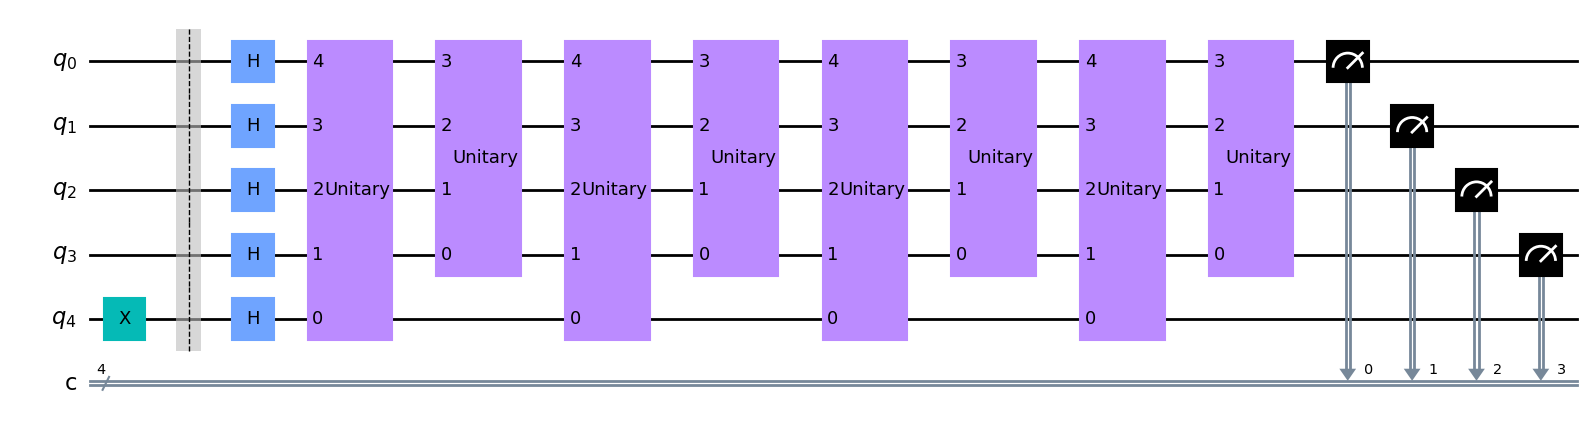

In [3]:
leng = 4
number = 2

qc = grover(leng, number)

backend = Aer.get_backend('qasm_simulator')
job = backend.run(qc, shots=1024)
result = job.result()
print(result.get_counts())
counts = dict(result.get_counts())
max = 0
for key, value in counts.items():
    if value > max:
        max = value
        maxKey = key

print (maxKey[::-1])
qc.draw('mpl')

# Shors factoring algorithm

In [5]:
def aMod15(a,x,size):
    qc = QuantumCircuit(size)
    for _ in range(x):
        if a in [2,13]:
            qc.swap(0,1)
            qc.swap(1,2)
            qc.swap(2,3)
        if a in [7,8]:
            qc.swap(2,3)
            qc.swap(1,2)
            qc.swap(0,1)
        if a == 11:
            qc.swap(1,3)
            qc.swap(0,2)
        if a in [7,11,13]:
            qc.x(range(size))
    unitary = qc.to_gate()
    return unitary.control(1)

def modExp(n,m,a):
    qc = QuantumCircuit(n+m,name='modExp')
    for i in range(n):
        qc.append(aMod15(a,2**i,m),[i]+list(range(n,m+n)))
    return Operator(qc).to_instruction()

def shor(n:int, m:int, a:int=2):
    qc = QuantumCircuit(n+m, n)
    
    qc.h(range(n))
    qc.x(n+m-1)
    qc.barrier()
    qc.append(modExp(n,m,a), range(n+m))
    qc.barrier()
    qc.append(Operator(QFT(n).inverse()).to_instruction(), range(n))

    qc.measure(range(n), range(n))
    return qc

def processMeasurement(measurement,n):
    binaryString = ''.join(map(str, measurement))
    measuredInt = int(binaryString,2)
    phase = measuredInt/(2**n)
    f = Fraction.from_float(phase).limit_denominator(n)
    _,r = f.numerator, f.denominator
    print ("corresponding phase",phase," r ",r)
    return r, phase

In [6]:
N = 15 # number to factor

coprime = False
while coprime == False:
    a = np.random.randint(2, N)
    if math.gcd(a,N) == 1 and a in [2,7,8,11,13]:
        coprime = True

factorFound = False
attempts = 0
print ("trying with a=",a,"and N=",N)
while factorFound == False:
    attempts += 1
    qc = shor(n,m,a)
    backend = Aer.get_backend('qasm_simulator')
    job = backend.run(qc, shots=1)
    result = job.result()
    counts = list(result.get_counts().keys())
    print ("attempts",attempts,"counts",counts)
    r, phase = processMeasurement(counts[0],n)
    if phase != 0:
        guesses = [math.gcd(a**(r//2)-1,N), math.gcd(a**(r//2)+1,N)]
        print ("guesses",guesses)
        for guess in guesses:
            if guess not in [1,N] and N%guess == 0:
                factorFound = True
                print ("Found non trivial factors of",N,"; ",guess,"and",N//guess)
                break

trying with a= 11 and N= 15
attempts 1 counts ['1000']
corresponding phase 0.5  r  2
guesses [5, 3]
Found non trivial factors of 15 ;  5 and 3


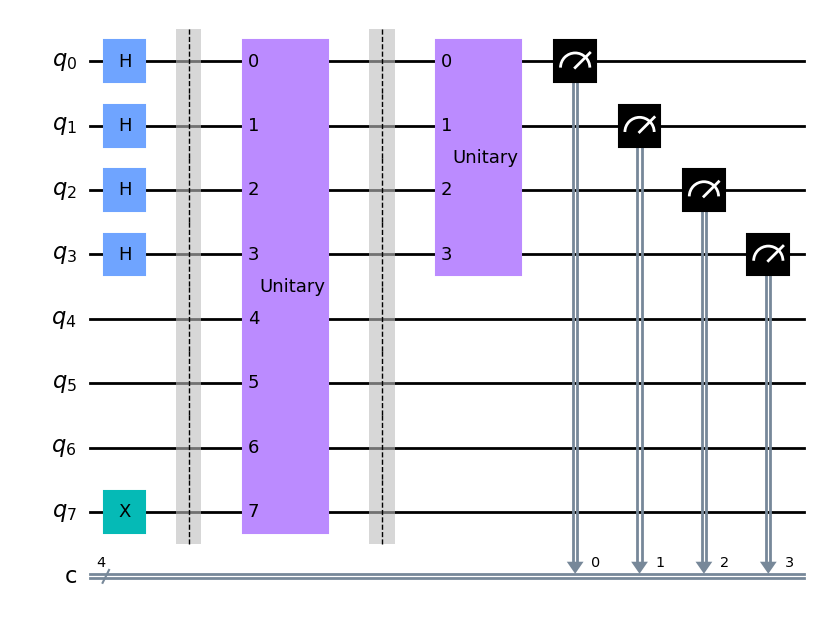

In [7]:
qc = shor(n,m)
qc.draw('mpl')

# Quantum lab
**FA1**. Duotajai qiskit schemai sympy priemonėmis raskite atitinkamą unitarinę transformaciją, atitinkamus tikrinius vektorius ir jų fazes. Užduoties variantai yra [>>>>](https://docs.google.com/document/d/1-y3EHC3zBhIUw13b7MMBeZGdQTyiWKQlb_RhP2Ez4n8/edit?usp=sharing)
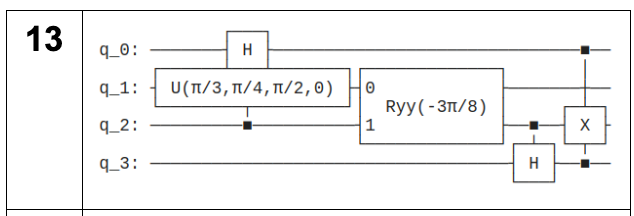

**FA2**. Sukurkite trijų kubitų  schemą, kurioje turi būti X, CX, H vartai. Jos  unitarinei matricai atlikite fazės aproksimacijos algoritmą qiskit aplinkoje. Palyginkite rastą $\theta$ reikšmę su tiksliąją (kurią Jūs galite rasti panašiai kaip FA1 užduotyje).

 **O1.** Duotiesiems $N$ ir $a$ raskite operatoriaus $M_a$ matricą (žr. daugiau [>>>>](https://learning.quantum-computing.ibm.com/course/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring#order-finding))

Variantai:
1. $N=27, a=10$

In [8]:
import numpy as np
from sympy import Array
from math import gcd

N = 27
a = 10

array = np.zeros((N,N))
for i in range(N):
    array[a*i%N][i] = 1

Array(array)

[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

**ShA**. Panagrinėkite Šoro algoritmo implementaciją [>>>>](https://https://learning.quantum-computing.ibm.com/course/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring#implementation-in-qiskit). Funkciją c_amod15(a) pakeiskite analogiška funkcija pagal Jūsų  variantą ir atlikite korekcijas kitose funkcijose taip, kad galima būtų išskaidyti duotąjį $N$:


1. $N=187$;


In [81]:
def getCoprimeListWithEvenPeriod(N):
    aList = []
    for i in range(N-1):
        if gcd(i,N) == 1 and i != 1:
            remainder = 0
            count = 1
            while remainder != 1:
                if remainder == 0:
                    remainder = (i)%N
                remainder = (remainder*i)%N
                count += 1
            if count%2 == 0:
                if gcd(i**(count//2)-1,N) != 1 and gcd(i**(count//2)+1,N) != 1:
                    aList.append(i)
    return aList

def generateAModMatrix(a,N):
    qc = QuantumCircuit(math.ceil(math.log(N,2)))
    qubits = math.ceil(math.log(N,2))
    matrix = np.zeros((2**qubits, 2**qubits))
    for i in range(0,2**qubits):
        if i < N:
            matrix[a*i%N][i] = 1
        else:
            matrix[i][i] = 1
    qc.unitary(matrix, range(qubits))
    return Operator(qc)

def aMod15(x,gat,size):
    qc = QuantumCircuit(size)
    for _ in range(x):
        qc.append(gat, range(size-1,-1,-1))
    unitary = qc.to_gate()
    print("unitary")
    return unitary.control(1)

def modExp(n,N,m,a):
    qc = QuantumCircuit(n+m,name='modExp')
    gate = generateAModMatrix(a,N)
    print(n)
    for i in range(n):
        qc.append(aMod15(2**i,gate, m),[i]+list(range(n,m+n)))
        print("appended")
    return Operator(qc)

def shor(n:int, N:int, m:int, a:int=2):
    qc = QuantumCircuit(n+m, n)
    
    qc.h(range(n))
    qc.x(n+m-1)
    qc.barrier()
    qc.append(modExp(n,N,m,a), range(n+m))
    print("modExp done")
    qc.barrier()
    qc.append(Operator(QFT(n).inverse()).to_instruction(), range(n))
    print("QFT done")

    qc.measure(range(n), range(n))
    return qc

def processMeasurement(measurement,n):
    binaryString = ''.join(map(str, measurement))
    measuredInt = int(binaryString,2)
    phase = measuredInt/(2**n)
    f = Fraction.from_float(phase).limit_denominator(n)
    _,r = f.numerator, f.denominator
    print ("corresponding phase",phase," r ",r)
    return r, phase

In [82]:
N = 21 # number to factor
# N = 187
n=math.ceil(math.log(N,2))
m=math.ceil(math.log(N,2))
coprimeListWithEvenPeriods = getCoprimeListWithEvenPeriod(N)
print (coprimeListWithEvenPeriods)
if len(coprimeListWithEvenPeriods) == 0:
    raise Exception('No coprime list with even periods found')
coprime = False
while coprime == False:
    a = np.random.randint(2, N)
    if a in coprimeListWithEvenPeriods:
        coprime = True

factorFound = False
attempts = 0
print ("trying with a=",a,"and N=",N)
qc = shor(n,N,m,a)
print("shor constructed")
t_gate = transpile(qc, backend, basis_gates=['cx', 'u3', 'u1', 'u2', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'cccx', 'cswap'])
while factorFound == False:
    attempts += 1
    backend = Aer.get_backend('qasm_simulator')
    job = backend.run(t_gate, shots=1)
    result = job.result()
    counts = list(result.get_counts().keys())
    print ("attempts",attempts,"counts",counts)
    r, phase = processMeasurement(counts[0],n)
    if phase != 0:
        guesses = [math.gcd(a**(r//2)-1,N), math.gcd(a**(r//2)+1,N)]
        print ("guesses",guesses)
        for guess in guesses:
            if guess not in [1,N] and N%guess == 0:
                factorFound = True
                print ("Found non trivial factors of",N,"; ",guess,"and",N//guess)
                break
qc.draw('mpl')

[2, 8, 10, 11, 13, 19]
trying with a= 2 and N= 21
5
unitary
appended
unitary
appended
unitary
appended
unitary
appended
unitary
appended


counts ['00000']


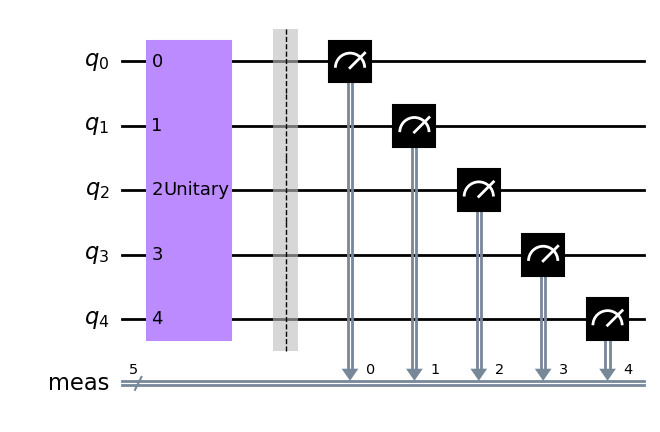

In [71]:
from qiskit import QuantumCircuit, Aer
N = 21
qubits = math.ceil(math.log(N,2))
qc = QuantumCircuit(qubits)
# t_gate = transpile(circuit, backend, basis_gates=['cx', 'u3', 'u1', 'u2', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'cccx', 'cswap'])

gate = generateAModMatrix(13,N)
qc.append(gate, range(qubits))
qc.measure_all()

backend = Aer.get_backend('qasm_simulator')
# t_gate = transpile(qc, backend, basis_gates=['cx', 'u3', 'u1', 'u2', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'swap', 'ccx', 'cccx', 'cswap'])
# job = backend.run(t_gate, shots=1)
job = backend.run(qc, shots=1)
result = job.result()
counts = list(result.get_counts().keys())
print ("counts",counts)
qc.draw('mpl')
# t_gate.decompose().draw('mpl')

